# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
TOPIC = "mondkapje"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = "human-labels-"+TOPIC+"-tweets.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"

In [3]:
tweets = pd.read_csv(FILETWEETS,header=None,index_col=0)
annotations = pd.read_csv(FILEANNOTATIONS,header=None,sep=" ")

In [4]:
fasttextData = {}
for i in range(0,len(annotations)):
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(tweets.loc[tweetId][2]))}

outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    if not fasttextData[tweetId][TEXT] in seenTexts:
        print(fasttextData[tweetId][LABEL],fasttextData[tweetId][USER],fasttextData[tweetId][TEXT],file=outFile)
        seenTexts[fasttextData[tweetId][TEXT]] = True
outFile.close()

## Fasttext run and evaluation

In [57]:
import fasttext
from IPython.display import clear_output

In [58]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [59]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [60]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()

In [61]:
DIM = 300
EPOCH = 100
LR = 0.1
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

predictionCounts = []
predictionLabels = []
for fold in range(0,N):
    clear_output(wait=True)
    print("starting fold",fold)
    testStart = round(fold*len(fasttextData)/N)
    testEnd = round((fold+1)*len(fasttextData)/N)
    trainFile = open(TRAIN,"w")
    testFile = open(TEST,"w")
    testData = []
    for i in range(0,len(fasttextData)):
        if i < testStart or i >= testEnd: print(fasttextData[i],file=trainFile)
        else: 
            print(fasttextData[i],file=testFile)
            testData.append(fasttextData[i])
    testFile.close()
    trainFile.close()
    model = fasttext.train_supervised(TRAIN,dim=DIM,epoch=EPOCH,lr=LR) # ,pretrainedVectors=PRETRAINEDDIR+WIKIFILENAME)
    predictionCounts.append([*model.test(TEST)])
    predictionLabels.append(model.predict(testData))
    os.unlink(TRAIN)
    os.unlink(TEST)
clear_output(wait=True)
print("finished")

finished


In [62]:
caseTotal = 0
pTotal = 0
rTotal = 0
for i in range(0,len(predictionCounts)):
    caseTotal += predictionCounts[i][0]
    pTotal += predictionCounts[i][0]*predictionCounts[i][1]
    rTotal += predictionCounts[i][0]*predictionCounts[i][2]
print("cases: {0}; precision: {1}; recall: {2}".format(caseTotal,round(pTotal/caseTotal,3),round(rTotal/caseTotal,3)))

cases: 593; precision: 0.637; recall: 0.637


In [63]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1

In [64]:
labelCountsGold

{'__label__NEUTRAL': 53,
 '__label__IRRELEVANT': 235,
 '__label__NEGATIVE': 273,
 '__label__POSITIVE': 32}

In [65]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1

In [66]:
labelCountsPredicted

{'__label__NEUTRAL': 24,
 '__label__NEGATIVE': 330,
 '__label__IRRELEVANT': 235,
 '__label__POSITIVE': 4}

Fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [67]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__NEUTRAL': 2.2083333333333335,
 '__label__IRRELEVANT': 1.0,
 '__label__NEGATIVE': 0.8272727272727273,
 '__label__POSITIVE': 8.0}

The multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [68]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

593.0 593


## Classifying tweets

In [41]:
import fasttext
import matplotlib

In [17]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
NEGATIVE = "__label__NEGATIVE"
POSITIVE = "__label__POSITIVE"
NEUTRAL = "__label__NEUTRAL"
IRRELEVANT = "__label__IRRELEVANT"
TEXT = "text"
USER = "user"
DIM = 300
EPOCH = 100
LR = 0.1

In [20]:
def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+"| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+"| grep \""+query+"\" >> "+tmpFileName)
            try: df = pd.read_csv(tmpFileName)
            except: continue
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT],flags=re.IGNORECASE):
                    testData.append(df.iloc[i][USER]+" "+df.iloc[i][TEXT])
    os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query):
    testData = readData(datePattern,query)
    model = fasttext.train_supervised(FILEFASTTEXT,dim=DIM,epoch=EPOCH,lr=LR) # ,pretrainedVectors=PRETRAINEDDIR+WIKIFILENAME)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    return(labelPercentages)

In [21]:
QUERY = "mondkapje"

results = {}
for month in "202002 202003 202004 202005 202006".split():
    for day in range(1,32):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY)
            results[date] = labels
            print(date,labels[NEGATIVE],labels[NEUTRAL],labels[POSITIVE],labels[IRRELEVANT])
        except:
            print(date,"error")

20200201 69.0 14.9 16.1 136.8
20200202 53.7 18.5 27.8 62.0
20200203 80.5 11.0 8.5 79.3
20200204 64.7 19.0 16.4 43.1
20200205 71.8 15.5 12.7 63.4
20200206 80.0 12.0 8.0 84.0
20200207 78.6 10.0 11.4 105.7
20200208 82.3 7.6 10.1 72.2
20200209 73.0 16.2 10.8 54.1
20200210 89.7 3.4 6.9 50.0
20200211 83.3 10.0 6.7 56.7
20200212 69.4 16.7 13.9 61.1
20200213 85.7 11.4 2.9 51.4
20200214 59.1 22.7 18.2 59.1
20200215 71.4 21.4 7.1 114.3
20200216 72.7 18.2 9.1 54.5
20200217 63.8 27.6 8.6 87.9
20200218 82.7 13.5 3.8 144.2
20200219 69.6 21.7 8.7 82.6
20200220 61.5 7.7 30.8 61.5
20200221 67.2 17.2 15.6 278.1
20200222 80.6 12.4 7.0 168.2
20200223 68.6 19.8 11.6 86.0
20200224 70.6 13.7 15.7 48.0
20200225 55.9 29.1 15.0 88.9
20200226 73.4 16.1 10.5 75.5
20200227 71.3 15.3 13.4 63.4
20200228 77.5 12.1 10.4 61.1
20200229 73.4 15.9 10.8 162.6
20200230 error
20200231 error
20200301 75.8 17.5 6.8 97.7
20200302 77.9 15.4 6.7 82.0
20200303 73.7 17.1 9.2 149.5
20200304 76.1 11.0 12.9 58.1
20200305 73.4 18.3 8.3

In [34]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

[1.0, 1.5, 2.0, 2.5, 3.0]

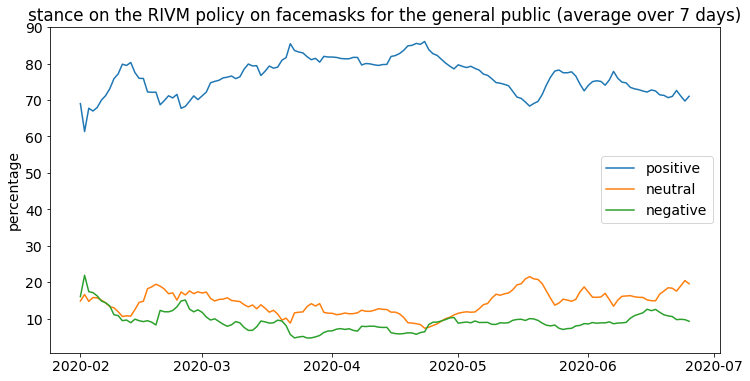

In [47]:
import matplotlib.pyplot as plt

DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7

results ={k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.figure(figsize=(12,6))
plt.plot_date([datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()],\
              movingAverage([labels[NEGATIVE] for labels in results.values()],DAYSCOMBINED),\
              fmt="-",label="positive")
plt.plot_date([datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()],\
              movingAverage([labels[NEUTRAL] for labels in results.values()],DAYSCOMBINED),\
              fmt="-",label="neutral")
plt.plot_date([datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()],\
              movingAverage([labels[POSITIVE] for labels in results.values()],DAYSCOMBINED),\
              fmt="-",label="negative")
plt.legend()
plt.title("stance on the RIVM policy on facemasks for the general public (average over "+str(DAYSCOMBINED)+" days)")
plt.ylabel("percentage")
plt.show()